# Find qubit relaxation rate using QISKit

### Authenticate yourself for remote access to IBM QX

In [1]:
# authenticate yourself for remote access
from qiskit import QuantumProgram
import Qconfig
qp = QuantumProgram()
qp.set_api(Qconfig.APItoken, Qconfig.config['url'])

### Select device and qubit to measure

In [2]:
# select device and qubit to measure T1 on
device = 'ibmqx5' # the device to run on
qubit = 2

### Read the qubit relaxation rate from latest calibration

In [3]:
# what we should expect to see
params = qp.get_backend_parameters(device)['qubits'][qubit]
str(params['T1']['value']) +' ' + params['T1']['unit']

'33.1 µs'

### Build benchmarking circuits

In [4]:
# set up registers
from qiskit import QuantumRegister, ClassicalRegister
qr = QuantumRegister('q', 5)
cr = ClassicalRegister('c', 5)

In [10]:
# build the quantum circuits
from qiskit import QuantumCircuit

# create varying length circuits
steps = 10
id_gates_per_step = 80
circuits = []
for i in range(steps):
    qc = QuantumCircuit(qr,cr)
    qc.x(qr[qubit])
    # pad identity (wait) gates
    for j in range(id_gates_per_step*i):
        qc.barrier(qr[qubit])
        qc.iden(qr[qubit])
    qc.measure(qr[qubit], cr[qubit])
    circuits.append(qc)

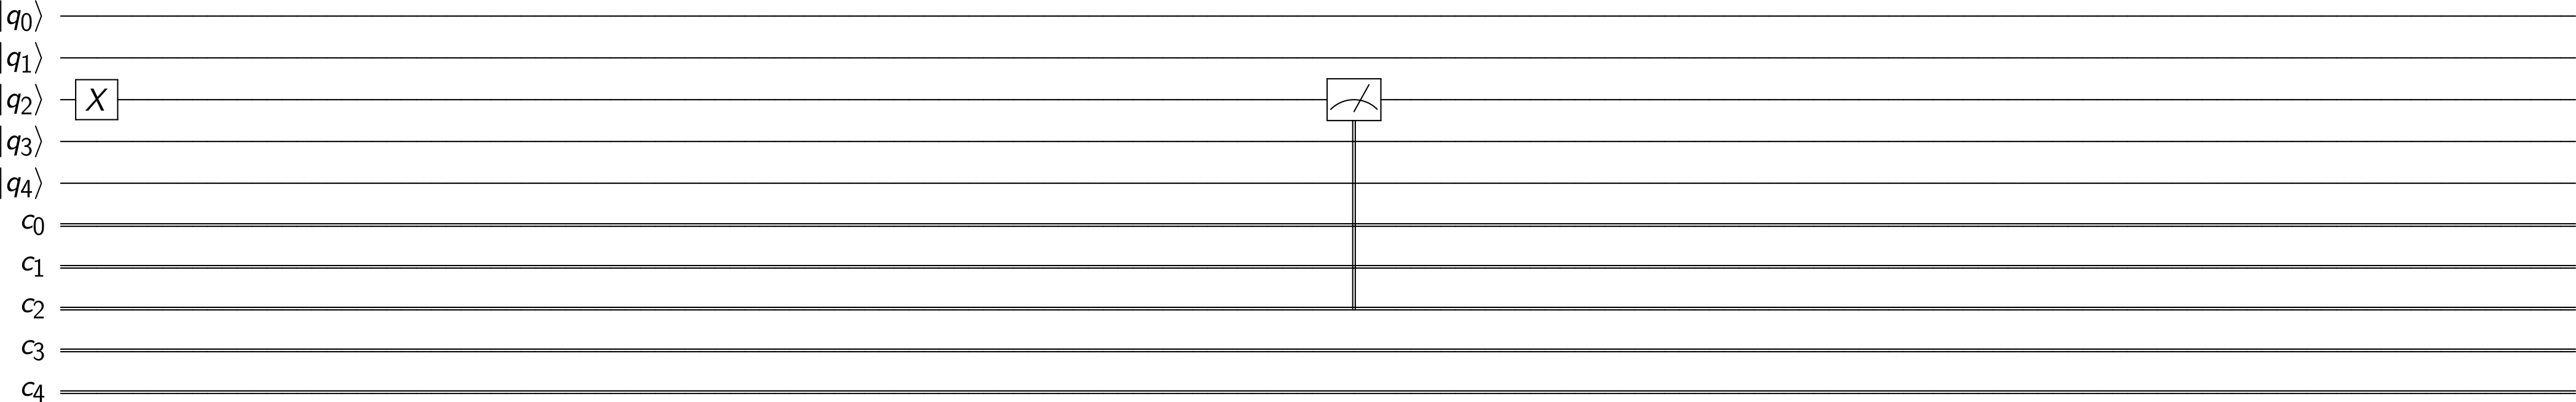

In [11]:
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(circuits[1])

### Add circuits to quantum program, and execute

In [12]:
# add circuits to quantum program
for idx, circuit in enumerate(circuits):
    qp.add_circuit(str(idx), circuit)

In [13]:
# run the program on hardware/simulator
shots=1024
%time result=qp.execute(qp.get_circuit_names(), backend=device, shots=shots, timeout=600)
print(result)

CPU times: user 2min 21s, sys: 4.1 s, total: 2min 25s
Wall time: 5min 33s
COMPLETED


### Analyze the result

circuit 0
{'0000000000000000': 109, '0000000000000100': 915}
circuit 1
{'0000000000000000': 196, '0000000000000100': 828}
circuit 2
{'0000000000000000': 322, '0000000000000100': 702}
circuit 3
{'0000000000000000': 429, '0000000000000100': 595}
circuit 4
{'0000000000000000': 531, '0000000000000100': 493}
circuit 5
{'0000000000000000': 587, '0000000000000100': 437}
circuit 6
{'0000000000000000': 644, '0000000000000100': 380}
circuit 7
{'0000000000000000': 701, '0000000000000100': 323}
circuit 8
{'0000000000000000': 714, '0000000000000100': 310}
circuit 9
{'0000000000000000': 748, '0000000000000100': 276}


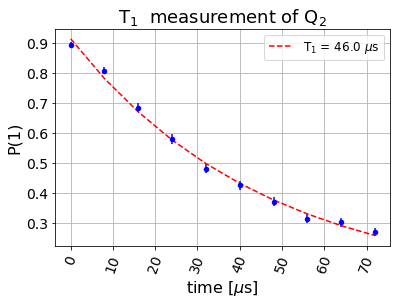

T1: 45.83 µs ± 6.03 µs


In [15]:
# arrange data from the runs
import numpy as np
from scipy.optimize import curve_fit
from qiskit.tools.qcvv.fitters import exp_fit_fun, plot_coherence

# convert from gate unit to time unit
pulse_length=params['gateTime']['value'] # single-qubit gate time 
buffer_length=params['buffer']['value']  # spacing between pulses
time_per_step = id_gates_per_step * (buffer_length + pulse_length)
plot_factor = 1000
unit='$\mu$s'
xvals = time_per_step * np.linspace(0, len(circuits), len(circuits)) / plot_factor

# gather average and standard deviation from the data
# in terms of probability of excited state 
num_qubits = qp.get_backend_configuration(device)["n_qubits"]
relaxed_state = '0' * num_qubits
excited_state = relaxed_state[:qubit] + '1' + relaxed_state[qubit+1:]
excited_state = excited_state[::-1]

data = np.zeros(len(circuits))
sigma_data = np.zeros(len(circuits))
for i, circuit_name in enumerate(qp.get_circuit_names()):
    data[i] = float(result.get_counts(circuit_name)[excited_state]) / shots
    sigma_data[i] = np.sqrt(data[i] * (1-data[i])) / np.sqrt(shots)
    print("circuit", circuit_name)
    print(result.get_counts(circuit_name))

# fit the data to an exponential    
fitT1, fcov = curve_fit(exp_fit_fun, xvals, data, bounds=([-1,2,0], [1., 500, 1])) 
ferr = np.sqrt(np.diag(fcov))

plot_coherence(xvals, data, sigma_data, 
               fitT1, exp_fit_fun, unit, 'T$_1$ ', qubit)

print("T1: " + str(round(fitT1[1],2))+ " µs" + u" \u00B1 " + str(round(ferr[1],2)) + ' µs')